In [19]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

from dismix_model import DisMixModel
from dataset import CocoChoralesTinyDataset
from dismix_loss import ELBOLoss, BarlowTwinsLoss
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
batch_size = 32
best_val_loss = float('inf')
np_improvement_steps = 0
max_steps = 10000000

# Usage Example
data_dir = '/home/buffett/NAS_189/cocochorales_output/main_dataset/'
train_dataset = CocoChoralesTinyDataset(data_dir, split='train')
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_data_loader_iter = iter(train_data_loader)

# valid_dataset = CocoChoralesTinyDataset(data_dir, split='valid')
# valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
# test_dataset = CocoChoralesTinyDataset(data_dir, split='test')
# test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [2]:
model = DisMixModel(
    input_dim=128, 
    latent_dim=64, 
    hidden_dim=256, 
    gru_hidden_dim=256,
    num_frames=10,
    pitch_classes=52,
    output_dim=128,    
).to(device)
model.load_state_dict(torch.load('best_model.pth', weights_only=False))


<All keys matched successfully>

In [ ]:
pitch_data = []
timbre_data = []
stem_data = []
max_steps = 1000

for step in tqdm(range(max_steps)):
    model.eval()
    
    # Call next() on the iterator
    try:
        batch = next(train_data_loader_iter)
    except StopIteration:
        train_data_loader_iter = iter(train_data_loader)  # Reset iterator
        batch = next(train_data_loader_iter)
        
    mixture = batch["mixture"].to(device)
    query = batch["query"].to(device)
    print(mixture.shape, query.shape)
    
    # pitch_annotation = batch["pitch_annotation"].to(device) # pitch_label = batch["pitch_label"].to(device)
        
    rec_mixture, pitch_latent, pitch_logits, timbre_latent, timbre_mean, timbre_logvar, eq = model(mixture, query)
    
    pitch_data.append(pitch_latent.cpu().detach().numpy())
    timbre_data.append(timbre_latent.cpu().detach().numpy())
    stem_data.append(batch["stem"])

In [8]:
timbre_data = np.stack(timbre_data)
timbre_data.shape

(100, 32, 64)

In [9]:
timbre_data = timbre_data.mean(axis=1)
timbre_data.shape

(100, 64)

In [ ]:
stem_data = [item for sublist in stem_data for item in sublist]
stem_data

In [25]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=1)

tsne_data = tsne.fit_transform(timbre_data)

/home/buffett/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.092s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.554877
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.675159
[t-SNE] KL divergence after 1000 iterations: 0.774510


In [26]:
tsne_data = pd.concat([pd.DataFrame(tsne_data, columns=["x", "y"]), pd.Series(stem_data, name="stem")], axis=1)

<Axes: xlabel='x', ylabel='y'>

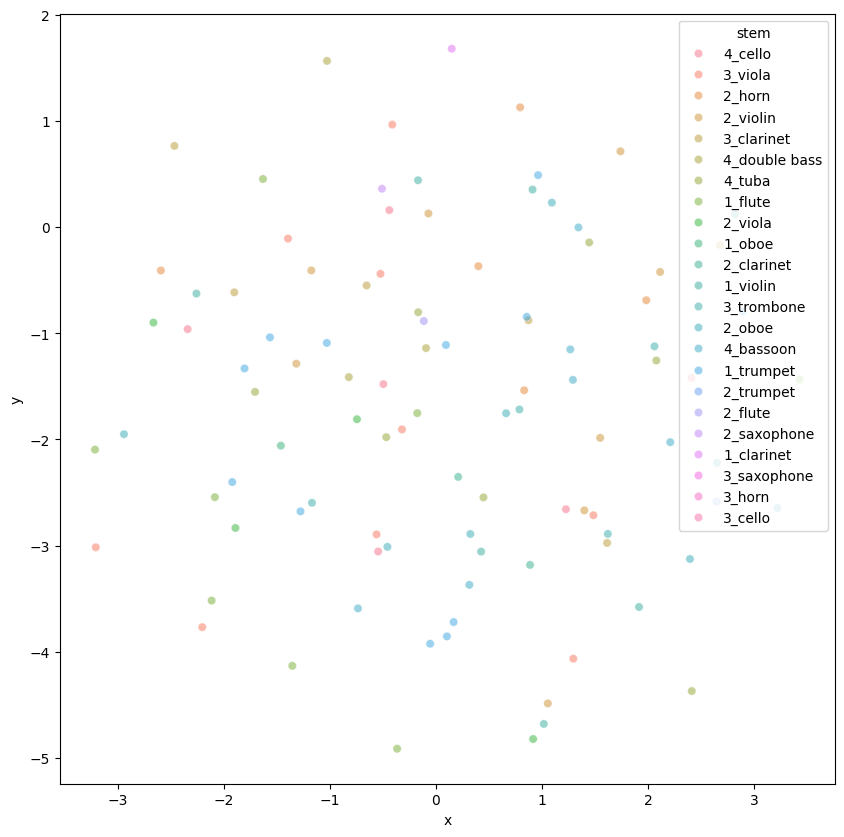

In [27]:
# tsne_fine = tsne_data[tsne_data["stem"].isin(FINE_LEVEL_INSTRUMENTS)]

plt.figure(figsize=(10, 10))
sns.scatterplot(data=tsne_data, x="x", y="y", hue="stem", alpha=0.5)